In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image
from facenet_pytorch import MTCNN
import torch
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import cv2
import zipfile
import imagehash
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from sklearn.metrics import mean_squared_error
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
import pandas as pd
from skimage.feature import hog
from skimage import exposure

Load your dataset

In [3]:
image_path = "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images"
faces_data = pd.read_csv("C:/Users/anand/Desktop/Final Project1 Human Face Hugging/faces.csv")

# Copy the dataframe
data = faces_data.copy()
data

image_name  width  height   x0   y0    x1   y1
0     00001722.jpg   1333    2000  490  320   687  664
1     00001044.jpg   2000    1333  791  119  1200  436
2     00001050.jpg    667    1000  304  155   407  331
3     00001736.jpg    626     417  147   14   519  303
4     00003121.jpg    626     418  462   60   599  166
...            ...    ...     ...  ...  ...   ...  ...
3345  00002232.jpg    620     349    4   36   186  158
3346  00002232.jpg    620     349  122  103   344  248
3347  00002232.jpg    620     349  258  118   541  303
3348  00002232.jpg    620     349  215   11   362  108
3349  00002232.jpg    620     349  330    1   487   81

[3350 rows x 7 columns]

In [4]:
data.head()

image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331
3  00001736.jpg    626     417  147   14   519  303
4  00003121.jpg    626     418  462   60   599  166

Remove duplicate or irrelevant images and correct any incorrect annotations.

In [6]:
# Check for duplicates
print("Number of duplicate rows:", data.duplicated().sum())

Number of duplicate rows: 0


In [7]:
# Remove duplicate rows 
data = data.drop_duplicates()
print("Shape after removing duplicates:", data.shape)

Shape after removing duplicates: (3350, 7)


In [8]:
# Check for null values 
print("Null values in each column:")
print(data.isnull().sum())

Null values in each column:
image_name    0
width         0
height        0
x0            0
y0            0
x1            0
y1            0
dtype: int64


In [9]:
#Full path of image
data["image_name"] = data["image_name"].apply(lambda x : os.path.join(image_path, x))
data.head()

image_name  width  height   x0   y0  \
0  C:/Users/anand/Desktop/Final Project1 Human Fa...   1333    2000  490  320   
1  C:/Users/anand/Desktop/Final Project1 Human Fa...   2000    1333  791  119   
2  C:/Users/anand/Desktop/Final Project1 Human Fa...    667    1000  304  155   
3  C:/Users/anand/Desktop/Final Project1 Human Fa...    626     417  147   14   
4  C:/Users/anand/Desktop/Final Project1 Human Fa...    626     418  462   60   

     x1   y1  
0   687  664  
1  1200  436  
2   407  331  
3   519  303  
4   599  166

# Normalizing x0,y0,x1,y1

In [11]:
data["x0"] = data["x0"]/data["width"]
data["y0"] = data["y0"]/data["height"]
data["x1"] = data["x1"]/data["width"]
data["y1"] = data["y1"]/data["height"]

In [12]:
data["x0"]

0       0.367592
1       0.395500
2       0.455772
3       0.234824
4       0.738019
          ...   
3345    0.006452
3346    0.196774
3347    0.416129
3348    0.346774
3349    0.532258
Name: x0, Length: 3350, dtype: float64

# Preprocessing The Data

In [14]:
def preprocessing(file_path, label, pred=False):

    img = tf.io.read_file(file_path)   #read the content of file
    img= tf.io.decode_jpeg(img, channels=3)  #convert image into tensor
    height_img = img.shape[0]
    width_img = img.shape[1]
    img  = tf.image.resize(img, [224,224])   #resize the image
    img  = tf.cast(img, tf.float32)/255.0    #Normalize the element of img tensor
    if pred:
        return img, width_img, height_img
    return img, label

# Creating the Dataset

In [16]:
def to_dataset(data):
    data_set = tf.data.Dataset.from_tensor_slices((data["image_name"],data.drop(columns = ["image_name","width","height"])))
    dataset = data_set.map(preprocessing)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [17]:
data

image_name  width  height  \
0     C:/Users/anand/Desktop/Final Project1 Human Fa...   1333    2000   
1     C:/Users/anand/Desktop/Final Project1 Human Fa...   2000    1333   
2     C:/Users/anand/Desktop/Final Project1 Human Fa...    667    1000   
3     C:/Users/anand/Desktop/Final Project1 Human Fa...    626     417   
4     C:/Users/anand/Desktop/Final Project1 Human Fa...    626     418   
...                                                 ...    ...     ...   
3345  C:/Users/anand/Desktop/Final Project1 Human Fa...    620     349   
3346  C:/Users/anand/Desktop/Final Project1 Human Fa...    620     349   
3347  C:/Users/anand/Desktop/Final Project1 Human Fa...    620     349   
3348  C:/Users/anand/Desktop/Final Project1 Human Fa...    620     349   
3349  C:/Users/anand/Desktop/Final Project1 Human Fa...    620     349   

            x0        y0        x1        y1  
0     0.367592  0.160000  0.515379  0.332000  
1     0.395500  0.089272  0.600000  0.327082  
2     0.455772  0.155000  0.610195  0.331000  
3     0.234824  0.033573  0.829073  0.726619  
4     0.738019  0.143541  0.956869  0.397129  
...        ...       ...       ...       ...  
3345  0.006452  0.103152  0.300000  0.452722  
3346  0.196774  0.295129  0.554839  0.710602  
3347  0.416129  0.338109  0.872581  0.868195  
3348  0.346774  0.031519  0.583871  0.309456  
3349  0.532258  0.002865  0.785484  0.232092  

[3350 rows x 7 columns]

Exploratory Data Analysis (EDA)

In [19]:
# Count the total number of unique Images & Faces
total_images = data['image_name'].nunique()
total_faces = len(data)
print(f"Total number of images: {total_images}")
print(f"Total number of faces: {total_faces}")

Total number of images: 2204
Total number of faces: 3350


In [20]:
# Group the data by image name and count the number of faces per image
faces_per_image = data.groupby('image_name').size().reset_index(name='face_count')

In [21]:
faces_per_image

image_name  face_count
0     C:/Users/anand/Desktop/Final Project1 Human Fa...           1
1     C:/Users/anand/Desktop/Final Project1 Human Fa...           1
2     C:/Users/anand/Desktop/Final Project1 Human Fa...           1
3     C:/Users/anand/Desktop/Final Project1 Human Fa...           1
4     C:/Users/anand/Desktop/Final Project1 Human Fa...           1
...                                                 ...         ...
2199  C:/Users/anand/Desktop/Final Project1 Human Fa...           1
2200  C:/Users/anand/Desktop/Final Project1 Human Fa...           2
2201  C:/Users/anand/Desktop/Final Project1 Human Fa...           1
2202  C:/Users/anand/Desktop/Final Project1 Human Fa...           1
2203  C:/Users/anand/Desktop/Final Project1 Human Fa...           4

[2204 rows x 2 columns]

In [22]:
# Additional analysis: Calculate the overall statistics for face density
average_faces_per_image = faces_per_image['face_count'].mean()
max_faces_per_image = faces_per_image['face_count'].max()
min_faces_per_image = faces_per_image['face_count'].min()

In [23]:
print(f"Average number of faces per image: {average_faces_per_image:.2f}")
print(f"Maximum number of faces per image: {max_faces_per_image}")
print(f"Minimum number of faces per image: {min_faces_per_image}")

Average number of faces per image: 1.52
Maximum number of faces per image: 12
Minimum number of faces per image: 1


VISUALIZATION

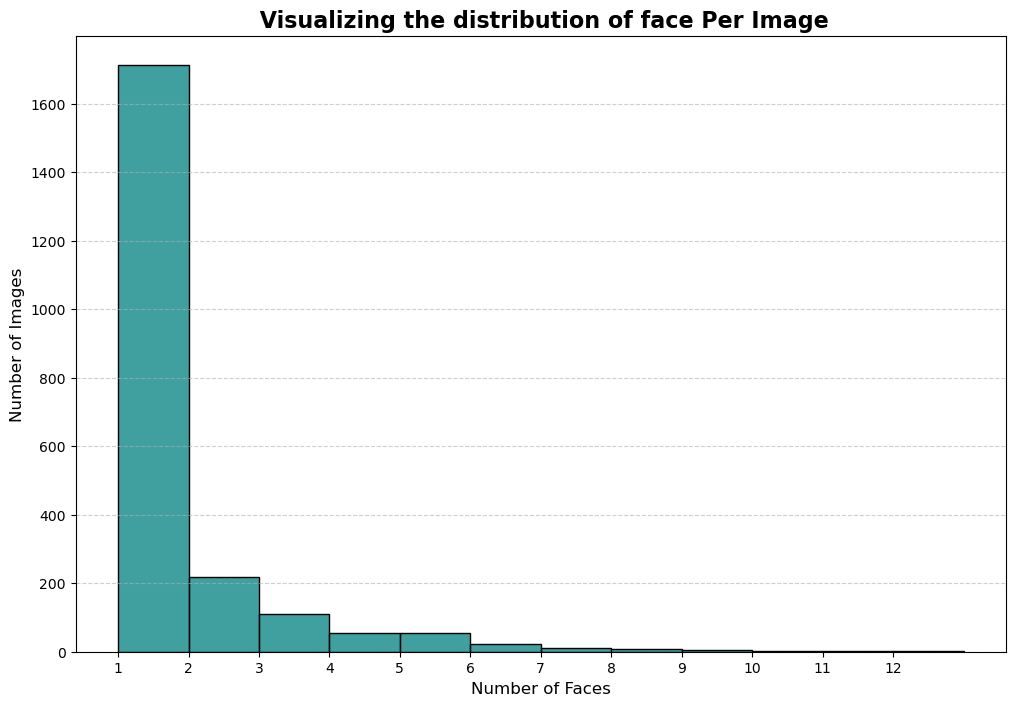

In [25]:
# Visualizing the distribution of Face Counts per image, the axes X and Y:

plt.figure(figsize=(12, 8))

# Plot histogram with custom bin size and style
sns.histplot(faces_per_image['face_count'], bins=range(1, max_faces_per_image + 2), kde=False, color='teal')

# Title and axis labels with clear and professional fonts
plt.title(' Visualizing the distribution of face Per Image', fontsize=16, fontweight='bold')
plt.xlabel('Number of Faces', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Adding grid and modifying the tick marks for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(range(1, max_faces_per_image + 1))  # Ensure all face counts are marked

plt.show()

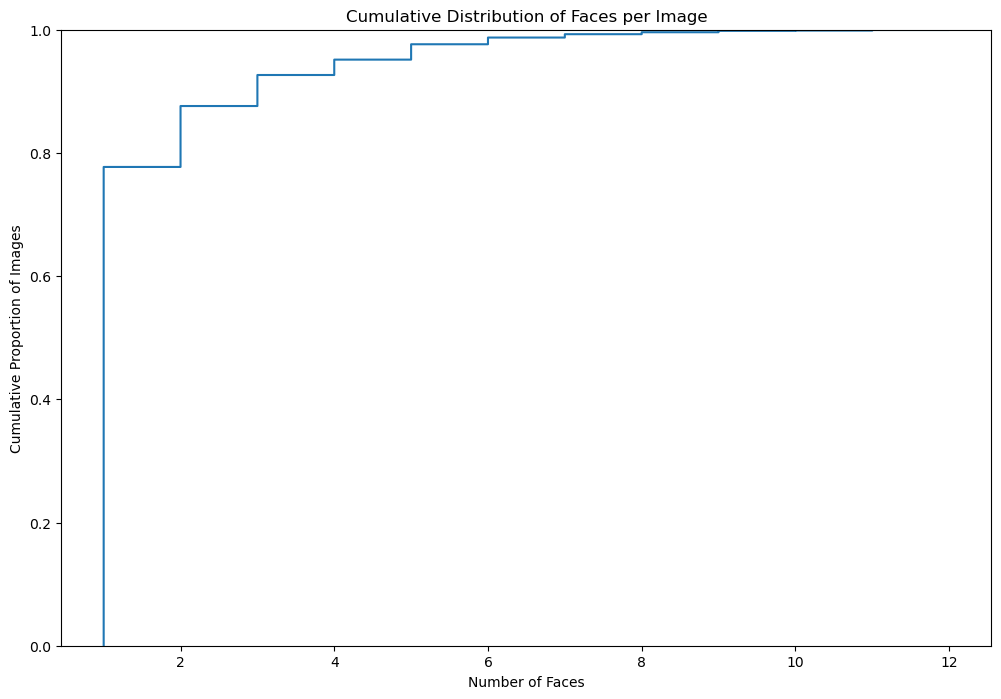

In [26]:
# Visualize the cumulative distribution of face counts per image

plt.figure(figsize=(12, 8))
sns.ecdfplot(faces_per_image['face_count'])
plt.title('Cumulative Distribution of Faces per Image')
plt.xlabel('Number of Faces')
plt.ylabel('Cumulative Proportion of Images')
plt.show()

# HOG (Histogram of Oriented Gradients): Extract Edge and Gradient Information for Face Detection.

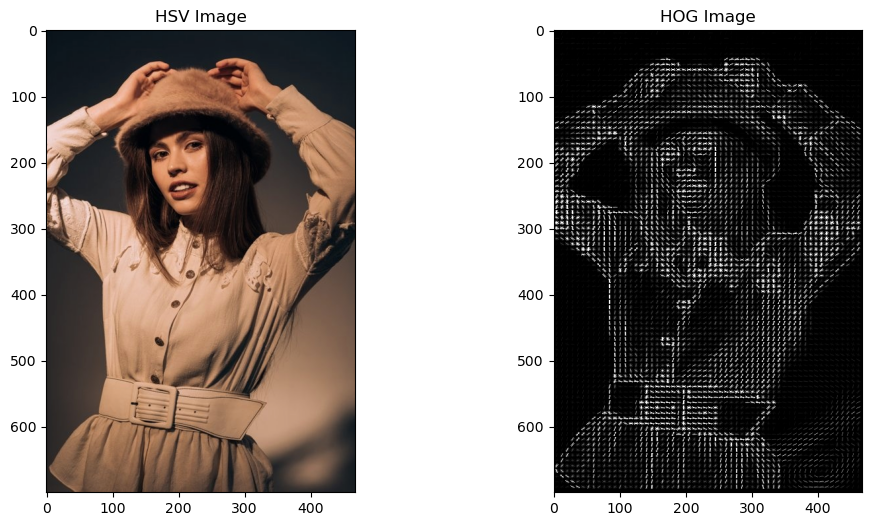

HOG features length: 176472


In [28]:
# Correct path to the image, ensuring it includes the filename and extension
image_path = "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000085.jpg"

# Load image
image = cv2.imread(image_path)

# Check if the image was loaded properly
if image is None:
    print(f"Error: Image not loaded. Please check the image path: {image_path}")
else:
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Compute HOG features on the grayscale version of the HSV image's V channel
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, hog_image = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Enhance the HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Save the HOG image to a file
    cv2.imwrite("hog_image.jpg", hog_image_rescaled)

    # Use matplotlib to display the images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB))
    plt.title("HSV Image")

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title("HOG Image")

    plt.show()

    # You can use `features` (flattened HOG features) for machine learning models
    print(f"HOG features length: {len(features)}")

# LBP (Local Binary Patterns) Works at Pixel Comparison, Binary to Decimal, and Feature Histogram.

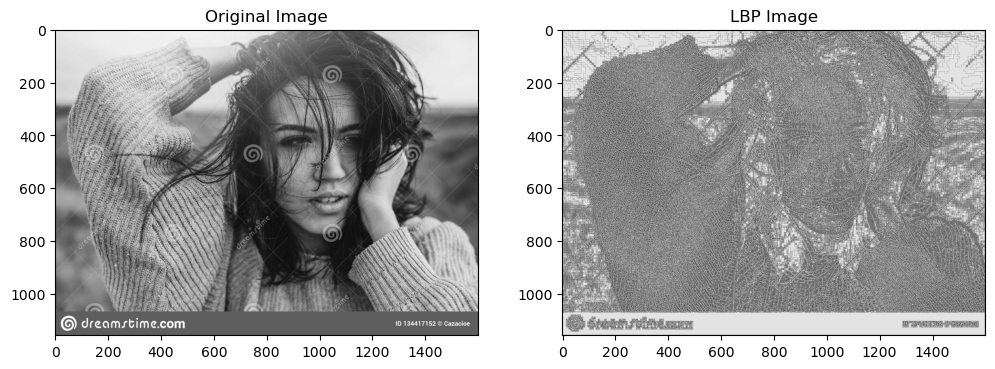

LBP features shape: (1157, 1600)
LBP histogram: (array([ 68471,  97531,  67123, 195220, 325907, 324839, 119928, 117306,
       387987, 146888], dtype=int64), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))


In [30]:
# Correct path to the image
image_path = "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000032.jpg"

# Load the image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded properly
if image is None:
    print(f"Error: Image not loaded. Please check the image path: {image_path}")
else:
    # Set parameters for LBP
    radius = 1  # Radius of the circle (default 1)
    n_points = 8 * radius  # Number of points to consider

    # Compute LBP features
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')

    # Plot the original image and the LBP image
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(lbp, cmap='gray')
    plt.title("LBP Image")

    plt.show()

    # Print LBP features (for example purposes)
    print(f"LBP features shape: {lbp.shape}")
    print(f"LBP histogram: {np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))}")

# Classification Model# YOLOV5 Model


In [32]:
# Directory containing images
image_dir = r"C:\Users\anand\Desktop\Final Project1 Human Face Hugging\images\images"
image_extensions = (".jpg", ".jpeg", ".png")  # Specify the image file extensions

# Load a pre-trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, yolov5n

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(image_extensions)]

# Count the total number of images
total_images = len(image_files)
print(f"Total images to process: {total_images}")

# Process a small count of images (e.g., 5 images)
num_images_to_process = 5
processed_images = 0

for image_file in image_files:
    if processed_images >= num_images_to_process:
        break
    
    image_path = os.path.join(image_dir, image_file)
    results = model(image_path)

    # Print results
    results.print()

    # Save results
    results.save(Path('path/to/save/directory'))

    # Access and print detections
    detections = results.pandas().xyxy  # bounding box coordinates
    print(detections)
    
    processed_images += 1

print(f"Processed {processed_images} images out of {total_images}")

Using cache found in C:\Users\anand/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-12-14 Python-3.12.4 torch-2.2.2+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
image 1/1: 350x500 1 person
Speed: 8.7ms pre-process, 113.5ms inference, 6.1ms NMS per image at shape (1, 3, 448, 640)


Total images to process: 2205


Saved 1 image to runs\detect\exp9998
image 1/1: 1241x1000 1 person, 1 potted plant
Speed: 17.1ms pre-process, 122.2ms inference, 1.0ms NMS per image at shape (1, 3, 640, 544)


[        xmin       ymin        xmax        ymax  confidence  class    name
0  76.714401  24.264944  245.769531  276.850769    0.932756      0  person]


Saved 1 image to runs\detect\exp9998
image 1/1: 957x1300 1 person
Speed: 11.6ms pre-process, 110.5ms inference, 0.0ms NMS per image at shape (1, 3, 480, 640)


[         xmin        ymin        xmax         ymax  confidence  class  \
0  324.099243  168.545135  654.916870  1089.039185    0.879309      0   
1  860.039673  123.611061  997.368774   478.396698    0.297017     58   

           name  
0        person  
1  potted plant  ]


Saved 1 image to runs\detect\exp9998


[         xmin        ymin         xmax        ymax  confidence  class    name
0  663.022034  156.558426  1170.905273  834.457275    0.847021      0  person]


image 1/1: 4000x2667 1 person
Speed: 76.4ms pre-process, 102.4ms inference, 1.1ms NMS per image at shape (1, 3, 640, 448)
Saved 1 image to runs\detect\exp9998
image 1/1: 867x1300 1 person, 4 kites
Speed: 9.8ms pre-process, 94.7ms inference, 7.8ms NMS per image at shape (1, 3, 448, 640)


[   xmin        ymin         xmax         ymax  confidence  class    name
0   0.0  691.122253  2651.978027  3988.571289    0.825097      0  person]


Saved 1 image to runs\detect\exp9998


[          xmin        ymin         xmax        ymax  confidence  class    name
0   211.390778  228.031784  1169.306519  794.161133    0.829562      0  person
1  1154.647705   51.470757  1259.928833  159.848816    0.769220     33    kite
2   420.361481   49.698620   526.369751  161.877991    0.517663     33    kite
3    37.866932   30.239929   160.124222  171.601837    0.505078     33    kite
4   772.873962   30.976156   893.815674  172.757828    0.412827     33    kite]
Processed 5 images out of 2205


 # Faster R-CNN with PyTorch

In [34]:
# Directory containing images
image_dir = r"C:\Users\anand\Desktop\Final Project1 Human Face Hugging\images\images"
image_extensions = (".jpg", ".jpeg", ".png")  # Specify the image file extensions

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(image_extensions)]

# Count the total number of images
total_images = len(image_files)
print(f"Total images to process: {total_images}")

# Process a small count of images (e.g., 5 images)
num_images_to_process = 5
processed_images = 0

for image_file in image_files:
    if processed_images >= num_images_to_process:
        break
    
    img_path = os.path.join(image_dir, image_file)
    img = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(img).unsqueeze(0)

    # Perform object detection
    with torch.no_grad():
        predictions = model(img_tensor)

    # Print results
    print(f"Results for {image_file}:")
    prediction = predictions[0]
    for idx, (box, label, score) in enumerate(zip(prediction['boxes'], prediction['labels'], prediction['scores'])):
        if score >= 0.5:  # Filter out low-confidence detections
            print(f"Detection {idx + 1}:")
            print(f"  Box: {box.tolist()}")
            print(f"  Label: {label.item()}")
            print(f"  Score: {score.item()}")

    processed_images += 1

print(f"Processed {processed_images} images out of {total_images}")

Total images to process: 2205
Results for 00000003.jpg:
Detection 1:
  Box: [79.01261138916016, 19.126245498657227, 252.33985900878906, 277.270751953125]
  Label: 1
  Score: 0.9995548129081726
Results for 00000004.jpg:
Detection 1:
  Box: [293.9532165527344, 182.53367614746094, 642.6256103515625, 1065.44482421875]
  Label: 1
  Score: 0.9987841248512268
Detection 2:
  Box: [857.2308959960938, 122.30146026611328, 999.7345581054688, 468.8139343261719]
  Label: 64
  Score: 0.8075826168060303
Results for 00000005.jpg:
Detection 1:
  Box: [647.7069091796875, 172.10885620117188, 1175.8883056640625, 832.0318603515625]
  Label: 1
  Score: 0.9987589120864868
Results for 00000006.jpg:
Detection 1:
  Box: [210.39901733398438, 810.0557250976562, 2558.152099609375, 3902.163330078125]
  Label: 1
  Score: 0.9913562536239624
Detection 2:
  Box: [159.0179901123047, 1911.3299560546875, 2594.366943359375, 3961.454345703125]
  Label: 65
  Score: 0.5683596730232239
Results for 00000008.jpg:
Detection 1:
  B

# Multi-task Cascaded Convolutional Networks(MTCNN) for Face Detection and Alignment 

In [94]:
from mtcnn import MTCNN
import matplotlib.patches as patches
from PIL import Image

# Initialize the MTCNN model
mtcnn = MTCNN()

# Directory containing images
image_dir = r"C:\Users\anand\Desktop\Final Project1 Human Face Hugging\images\images"
image_extensions = (".jpg", ".jpeg", ".png")  # Specify the image file extensions

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(image_extensions)]

# Count the total number of images
total_images = len(image_files)
print(f"Total images to process: {total_images}")

# Process a small count of images (e.g., 5 images)
num_images_to_process = 5
processed_images = 0

for image_file in image_files:
    if processed_images >= num_images_to_process:
        break
    
    img_path = os.path.join(image_dir, image_file)
    img = Image.open(img_path)

    # Perform face detection
    results = mtcnn.detect_faces(np.array(img))

    # Convert the image to numpy array for display
    img_np = np.array(img)

    # Create a figure and axis with matplotlib
    fig, ax = plt.subplots(1)
    ax.imshow(img_np)

    # Draw bounding boxes around detected faces
    if results is not None:
        for result in results:
            box = result['box']
            rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    # Display the image with bounding boxes
    plt.title(image_file)
    plt.show()

    processed_images += 10

print(f"Processed {processed_images} images out of {total_images}")

Total images to process: 2205
Processed 10 images out of 2205


In [36]:
# Split the data
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Verify the split
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 2680
Test set size: 670


# Train the Model

In [38]:
import ssl
import tensorflow as tf
ssl._create_default_https_context = ssl._create_unverified_context

# Transfer learning (using pretrained model Restnet50)
re_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    # input_tensor=None,
    input_shape=(224,224,3)
)

In [39]:
#creating the model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten,AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

# Build the model
x = re_model.output
x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D to reduce dimensions
x = Dense(250, activation="relu")(x)
x = Dense(250, activation="relu")(x)
output = Dense(4, activation="linear")(x)  # Assuming 4 output classes or regression outputs
model = Model(inputs=re_model.input, outputs=output)

In [40]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Adjust based on your specific problem
              metrics=['accuracy'])

In [41]:
# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,163,716 (92.18 MB)

 Trainable params: 24,110,596 (91.97 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [42]:
# Create datasets
train_dataset = to_dataset(train_df)
test_dataset = to_dataset(test_df)

In [43]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=2,  # Adjust based on your needs
    verbose=1
)

Epoch 1/2
84/84 ━━━━━━━━━━━━━━━━━━━━ 538s 6s/step - accuracy: 0.6286 - loss: 0.3436 - val_accuracy: 0.0000e+00 - val_loss: 1.0101
Epoch 2/2
84/84 ━━━━━━━━━━━━━━━━━━━━ 498s 6s/step - accuracy: 0.7550 - loss: 0.0220 - val_accuracy: 0.7955 - val_loss: 0.0493


In [44]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7988 - loss: 0.0490
Test Loss: 0.04930773377418518
Test Accuracy: 0.7955223917961121


In [45]:
# Plot training & validation accuracy values
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [46]:
# Plot Training & Validation Loss
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [47]:
from sklearn.metrics import precision_recall_fscore_support

# Make predictions on the test dataset
y_true = []
y_pred = []

for image, label in test_dataset.unbatch():
    y_true.append(label.numpy())
    y_pred.append(model.predict(tf.expand_dims(image, axis=0)).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━

In [48]:
# Calculate Mean Squared Error

y_true = [3, 0, 2, 7]
y_pred = [2.5, -0.3, 2, 8]

# Convert lists to NumPy arrays
y_true_flat = np.array(y_true).flatten()
y_pred_flat = np.array(y_pred).flatten()

mse = mean_squared_error(y_true_flat, y_pred_flat)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.33499999999999996


In [49]:
# Calculate Intersection Over Union (IOU)
# Define the calculate_iou function

def calculate_iou(box1, box2): 
    x1, y1, x2, y2 = box1 
    x1g, y1g, x2g, y2g = box2 
    
    xi1, yi1, xi2, yi2 = max(x1, x1g), max(y1, y1g), min(x2, x2g), min(y2, y2g) 
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1) 
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g) 
    union_area = box1_area + box2_area - inter_area 
    iou = inter_area / union_area 
    return iou

# Example true and predicted bounding boxes
y_true = [(50, 50, 150, 150), (30, 30, 120, 120), (60, 60, 170, 170)]
y_pred = [(55, 55, 155, 155), (35, 35, 125, 125), (70, 70, 160, 160)]

# Calculate IoU for each bounding box
ious = [] 
for i in range(len(y_true)): 
   iou = calculate_iou(y_true[i], y_pred[i]) 
   ious.append(iou) 
    
# Calculate mean IoU
mean_iou = np.mean(ious) 
print(f"Mean Intersection over Union (IoU): {mean_iou}")

Mean Intersection over Union (IoU): 0.7655862925314952


In [50]:
# Model is Save in your trained Keras model
model.save("my_model.keras")
print("Model saved successfully in .keras format")

Model saved successfully in .keras format


Load the Preprocessed Model

In [96]:
# Load the saved model
model = tf.keras.models.load_model("my_model.keras")

Preprocessing The Data

In [103]:
from tensorflow.keras.datasets import mnist
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the dataset further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Ensure the data has the correct shape (adding channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Check the shapes of the datasets
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step
Training data shape: (42000, 28, 28, 1)
Validation data shape: (18000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


Compile The Model And Accuracy Test

In [114]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess a limited number of images to avoid memory issues
def preprocess_images(images, limit=20):
    # Expand dimensions to add the channel dimension
    images = np.expand_dims(images[:limit], axis=-1)
    # Resize images to 224x224 and convert to RGB
    images_resized = np.array([img_to_array(array_to_img(img).resize((224, 224)).convert('RGB')) for img in images])
    return images_resized

# Process only 20 images for training, validation, and testing
X_train_small = preprocess_images(X_train)
X_val_small = preprocess_images(X_test, limit=10)
X_test_small = preprocess_images(X_test, limit=10)

y_train_small = y_train[:20]
y_val_small = y_test[:10]
y_test_small = y_test[:10]

# Normalize the data
X_train_small = X_train_small / 255.0
X_val_small = X_val_small / 255.0
X_test_small = X_test_small / 255.0

# Check the shapes
print(f"Training data shape: {X_train_small.shape}")
print(f"Validation data shape: {X_val_small.shape}")
print(f"Test data shape: {X_test_small.shape}")

# Build a new model if necessary
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Ensure the output layer has 10 units
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with the small dataset
history = model.fit(X_train_small, y_train_small, epochs=10, batch_size=4, validation_data=(X_val_small, y_val_small))

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate model performance
val_predictions = model.predict(X_val_small)
val_accuracy = np.mean(np.argmax(val_predictions, axis=1) == y_val_small)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Test performance
test_predictions = model.predict(X_test_small)
y_pred = np.argmax(test_predictions, axis=1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_accuracy = accuracy_score(y_test_small, y_pred)
test_precision = precision_score(y_test_small, y_pred, average='macro')
test_recall = recall_score(y_test_small, y_pred, average='macro')
test_f1 = f1_score(y_test_small, y_pred, average='macro')

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-score: {test_f1:.2f}")


Training data shape: (20, 224, 224, 3)
Validation data shape: (10, 224, 224, 3)
Test data shape: (10, 224, 224, 3)
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 589ms/step - accuracy: 0.0437 - loss: 14.2369 - val_accuracy: 0.3000 - val_loss: 5.3596
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.5021 - loss: 2.2498 - val_accuracy: 0.3000 - val_loss: 3.1028
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - accuracy: 0.8181 - loss: 0.5659 - val_accuracy: 0.2000 - val_loss: 3.4508
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - accuracy: 1.0000 - loss: 0.1535 - val_accuracy: 0.2000 - val_loss: 3.7123
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step - accuracy: 1.0000 - loss: 0.0358 - val_accuracy: 0.1000 - val_loss: 3.5906
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 0.3000 - val_loss: 3.3091
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 0.3000 - val_loss: 3.0846
Ep

In [116]:
# Save the final model
model.save("my_model_final.keras")

In [189]:
print(model)

<Functional name=functional, built=True>


Model Deployment and Monitoring

In [120]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model
model = load_model("my_model_final.keras")

# Example prediction
import numpy as np
sample_data = np.random.random((1, 224, 224, 3))
prediction = model.predict(sample_data)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[[    0.99897  1.2161e-29  6.4448e-25  1.2305e-08  1.9225e-31  0.00091357  0.00011671  1.5728e-26  2.3008e-26  5.5586e-19]]


In [205]:
def visualize_predictions(img_paths):
    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(img_paths):
        # Preprocess image
        img = plt.imread(img_path)
        img_resized = tf.image.resize(img, [224, 224])
        img_resized = img_resized / 255.0
        img_resized = tf.expand_dims(img_resized, axis=0)

        # Make prediction
        pred = model.predict(img_resized)

        # Display the image
        plt.subplot(2, 5, i + 1)  # Adjust grid size based on the number of images
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Pred: {np.argmax(pred)}')

    plt.tight_layout()
    plt.show()

# Example usage with some image file paths
image_paths = [
     "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000032.jpg",
     "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000085.jpg"
    # Add more image paths as needed
]
visualize_predictions(image_paths)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 Model Deployment and Monitoring

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


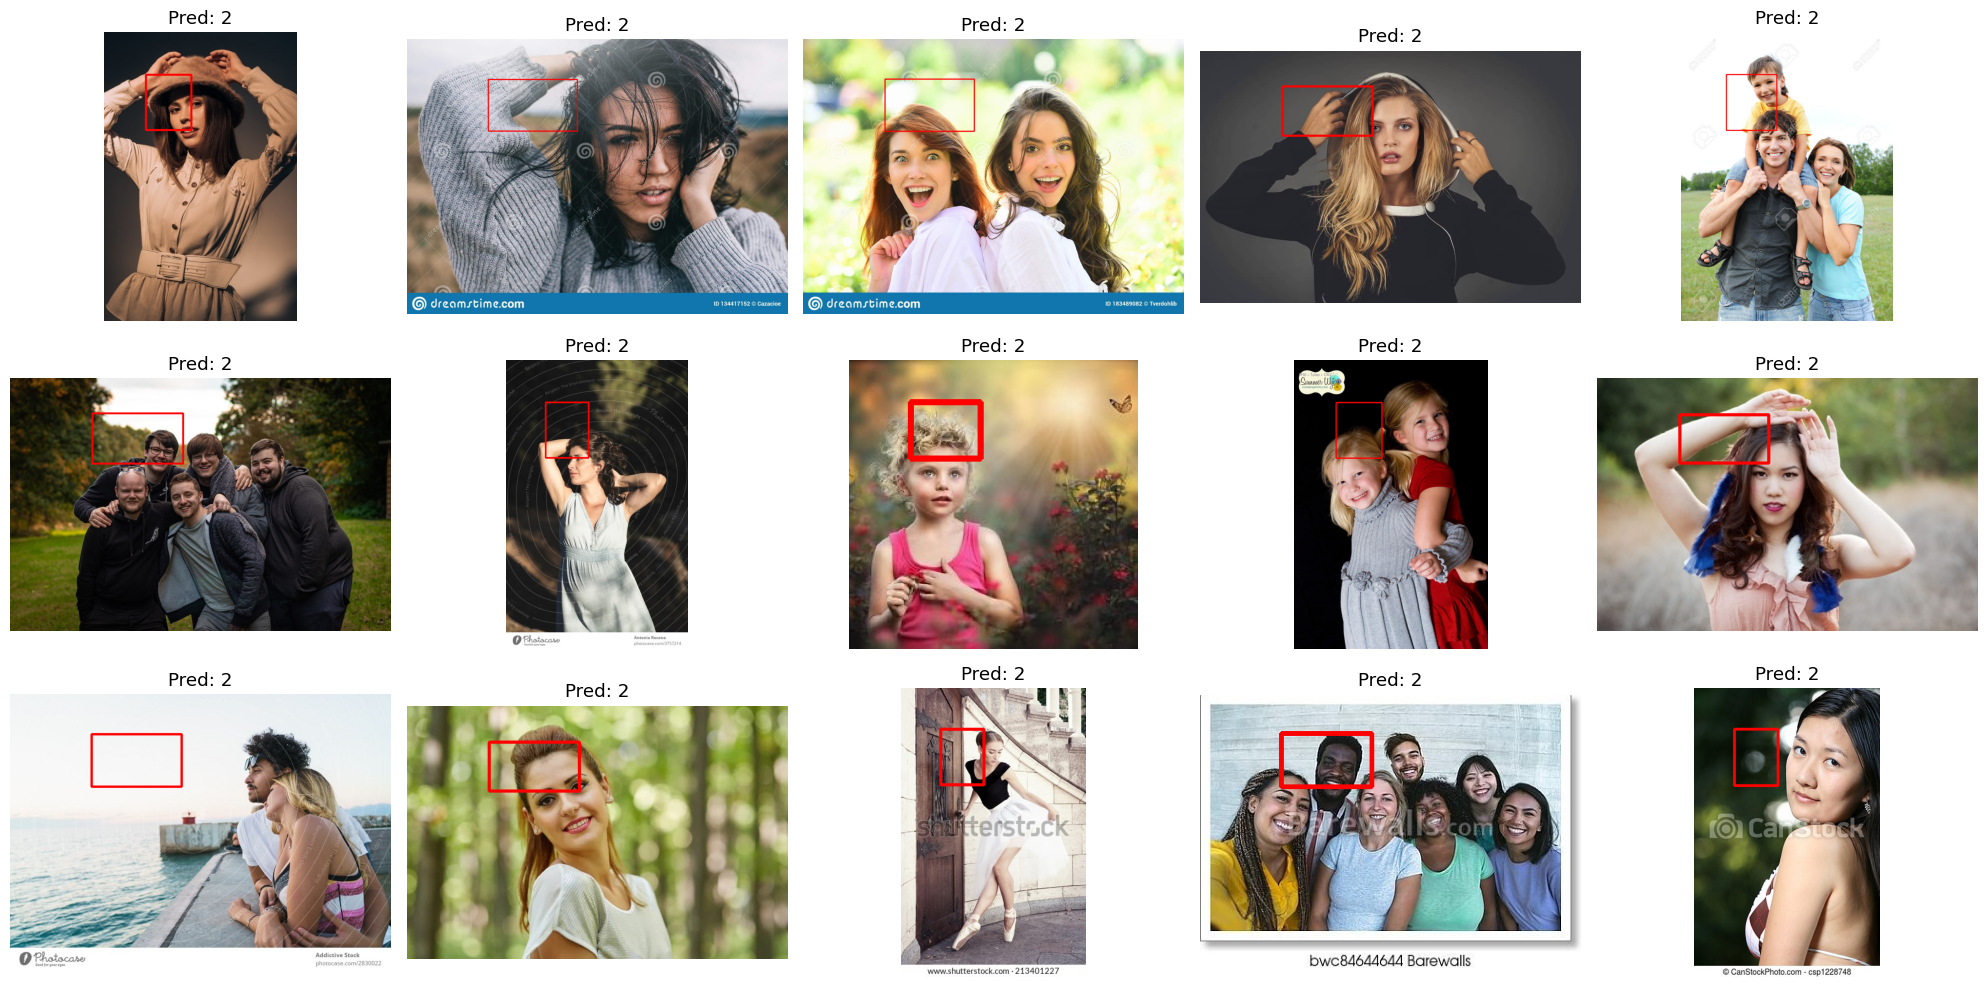

In [237]:
# Ensure Matplotlib backend is set for Jupyter
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

# Function to visualize predictions with bounding boxes
def visualize_predictions(img_paths):
    plt.figure(figsize=(20, 10))  # Adjust the size for better visualization

    for i, img_path in enumerate(img_paths):
        # Preprocess image
        img = plt.imread(img_path)
        img_resized = tf.image.resize(img, [224, 224])
        img_resized = img_resized / 255.0
        img_resized = tf.expand_dims(img_resized, axis=0)

        # Make prediction
        pred = model.predict(img_resized)

        # Read the image for drawing boxes
        imr = cv2.imread(img_path)
        imr = cv2.cvtColor(imr, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Assume pred[0] contains bounding box coordinates
        # Scale predictions back to original image dimensions
        h, w, _ = imr.shape
        x0 = int(pred[0][0] * w)
        y0 = int(pred[0][1] * h)
        x1 = int(pred[0][2] * w)
        y1 = int(pred[0][3] * h)

        # Draw rectangle on image
        p1 = (x0, y0)
        p2 = (x1, y1)
        color = (255, 0, 0)  # Red color
        thickness = 3
        cv2.rectangle(imr, p1, p2, color, thickness)

        # Display the image in a grid
        plt.subplot(3, 5, i + 1)  # Adjust grid size based on the number of images
        plt.imshow(imr)
        plt.axis('off')
        plt.title(f'Pred: {np.argmax(pred)}')

    plt.tight_layout()
    plt.show()

# Example usage with some image file paths
image_paths = [
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000085.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000032.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000026.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000044.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000104.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000159.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000211.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00003507.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00003308.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000012.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000340.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000396.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000204.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00000520.jpg",
    "C:/Users/anand/Desktop/Final Project1 Human Face Hugging/images/images/00001535.jpg"
    # Add more image paths as needed
]
visualize_predictions(image_paths)